In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
import os

In [4]:
os.chdir('/content/drive/MyDrive/Javiera_Research')

In [5]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


In [6]:
!ls cleaned_data/

brain_56cols_kmeans4_binary.csv
brain_56cols_kmeans4_binary_filtered.csv
brain_56cols_kmeans4.csv
brain_56cols_kmeans4_filtered.csv
Codings.csv
cols_deleted.txt
df_cluster_encoded.csv
df_result_base.csv
df_result_grid.csv
fil_1yr_53cols_pos_all.csv
fil_1yr_53cols_pos_mixed.csv
fil_1yr_64cols_pos_mixed.csv
fil_1yr_66cols_pos_mixed.csv
fil_1yr_correlation_cols_pos_all.csv
fil_columns.txt
javie_filtered_cols.csv
kmeans_grid_dict.json
kmedoids_grid_dict.json
og_columns.txt
ukb43673_57cols.csv
ukb43673_61cols_1yr.csv
ukb43673_72cols.csv
ukb43673_74cols_1yr.csv
ukb43673_74cols_6mo.csv
ukb43673_76cols_1yr.csv
ukb43673_brain_56cols_1yr.csv
ukb43673_correlation_cols_1yr.csv
ukb_response_impute_ref_stats_group_ds3.csv


# Imports

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib.cm as cm
import matplotlib.animation as animation
import datetime
from dateutil.relativedelta import relativedelta

import imblearn

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import gower

# setup linear tqdm
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# load data

In [8]:
df_og = pd.read_csv('cleaned_data/df_result_grid.csv')
  # this is the original questionnaire df after filter out -818 and -121 rows in all columns, both ordinal and numerical
  # appended with the clustering results for different k
  # should have shape (5772,73)
df_og

,eid,31-0.0,53-2.0,20400-0.0,20458-0.0,20459-0.0,20460-0.0,20479-0.0,20485-0.0,20495-0.0,20497-0.0,20498-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21025-0.0,21033-0.0,21034-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21057-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,center2_time_lapse1,center2_time_lapse2,kmedoid_cluster_13,kmedoid_cluster_12,kmedoid_cluster_11,kmedoid_cluster_10,kmedoid_cluster_9,kmedoid_cluster_8,kmedoid_cluster_7,kmedoid_cluster_6,kmedoid_cluster_5,kmedoid_cluster_4,kmeans_cluster_13,kmeans_cluster_12,kmeans_cluster_11,kmeans_cluster_10,kmeans_cluster_9,kmeans_cluster_8,kmeans_cluster_7,kmeans_cluster_6,kmeans_cluster_5,kmeans_cluster_4
0,1000993,1.0,2017-06-21,2016-07-28,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,59.0,2017-04-11,0.0,-500.0,-501.0,1.0,0.0,3.0,5.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,328 days,71 days,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1001367,1.0,2017-08-16,2016-09-30,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.0,2017-08-24,4.0,-503.0,-501.0,8.0,0.0,1.0,7.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,320 days,-8 days,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1003110,1.0,2016-05-25,2016-08-18,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,64.0,2017-04-28,0.0,-500.0,-501.0,1.0,0.0,2.0,6.0,1.0,-600.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-85 days,-338 days,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1003823,1.0,2016-05-31,2016-08-24,2.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,59.0,2017-05-05,0.0,-501.0,-500.0,1.0,2.0,2.0,3.0,1.0,-600.0,-601.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,-85 days,-339 days,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0
4,1004315,0.0,2017-09-15,2017-04-25,4.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,53.0,2017-04-25,3.0,-500.0,-501.0,1.0,1.0,2.0,5.0,1.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,-313.0,-600.0,-601.0,-602.0,-601.0,143 days,143 days,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,6021110,1.0,2016-07-25,2016-08-19,3.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,2017-05-04,1.0,-500.0,-500.0,1.0,0.0,3.0,1.0,2.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-313.0,-600.0,-600.0,-600.0,-600.0,-25 days,-283 days,7.0,12.0,11.0,10.0,2.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5768,6022430,1.0,2016-12-18,2016-12-12,1.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-04-28,0.0,-500.0,-500.0,2.0,0.0,2.0,7.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-602.0,-600.0,-600.0,-601.0,6 days,-131 days,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5769,6022902,1.0,2017-09-09,2016-09-22,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-05-20,5.0,-501.0,-501.0,2.0,

In [9]:
# keep only the eid column and the k=4 kmeans column to match with the brain data
df_temp = df_og[['eid','kmeans_cluster_4']]

In [10]:
df_brain = pd.read_csv('cleaned_data/ukb43673_brain_56cols_1yr.csv')
  # this is the original brain df after keeping only the columns Javi listed and only the rows matching the 'eid' of only 1yr gaps
  # should have shape (6287 ,56)
df_brain

,eid,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
0,1000993,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1,1001367,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
2,1003110,NaN,NaN,NaN,NaN,NaN,NaN,0.515724,0.484649,0.001474,0.000866,0.000869,0.531748,0.504692,0.316218,0.314996,0.548032,0.531419,0.423061,0.387133,0.362997,0.366122,0.000769,0.000771,0.000877,0.000905,0.000758,0.000776,0.000907,0.000929,0.000829,0.000843,21736.8,25180.0,6473.89,6883.81,1395.98,1444.92,4326.74,5068.76,5540.58,5670.42,6999.42,6313.67,2789.37,3560.78,1717.28,1383.63,1482.760,1198.490,2597.30,2759.24,4548.14,5094.23,2141.57,2364.66
3,1003668,9348.0,9322.0,4973.0,5218.0,1003.0,1694.0,0.565118,0.563306,0.001107,0.000813,0.000837,0.568728,0.546719,0.344964,0.339941,0.566609,0.567653,0.433444,0.440910,0.444479,0.420357,0.000761,0.000744,0.000805,0.000839,0.000758,0.000763,0.000866,0.000895,0.000740,0.000744,26738.3,30505.6,6917.96,6766.75,2706.68,2790.60,5307.60,5310.91,5830.16,5748.91,7714.26,7165.02,3580.95,3988.04,2018.60,1573.53,1782.870,1624.730,2728.45,2949.75,5222.12,5341.69,2506.20,2785.57
4,1003823,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6282,6021110,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.69,2455.27,2327.11,4599.56,5716.81,6609.43,7018.91,7729.63,7073.29,2686.76,3132.17,2190.75,1491.06,1837.540,1142.600,2634.73,2791.85,4734.81,4616.08,2015.03,2285.03
6283,6022430,8719.0,8696.0,3783.0,4457.0,1232.0,1103.0,0.559929,0.543902,0.001473,0.000861,0.000830,0.526542,0.521600,0.371121,0.348886,0.545633,0.535560,0.412591,0.410387,0.372528,0.369844,0.000776,0.000769,0.000827,0.000866,0.000785,0.000792,0.000931,0.000892,0.000814,0.000831,24700.5,27232.6,7218.52,7201.46,1952.68,1436.59,5615.63,6577.97,5403.41,5445.32,6675.56,6964.40,2976.54,3126.36,1934.18,1320.40,

In [11]:
df = df_temp.merge(df_brain, how='left', on='eid')
  # should have shape (5772,57)
print(df.shape)
df.set_index('eid',inplace=True)
  # set the column 'eid' as index
df

(5772, 57)


,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000993,1.0,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1001367,1.0,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
1003110,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.515724,0.484649,0.001474,0.000866,0.000869,0.531748,0.504692,0.316218,0.314996,0.548032,0.531419,0.423061,0.387133,0.362997,0.366122,0.000769,0.000771,0.000877,0.000905,0.000758,0.000776,0.000907,0.000929,0.000829,0.000843,21736.8,25180.0,6473.89,6883.81,1395.98,1444.92,4326.74,5068.76,5540.58,5670.42,6999.42,6313.67,2789.37,3560.78,1717.28,1383.63,1482.760,1198.490,2597.30,2759.24,4548.14,5094.23,2141.57,2364.66
1003823,1.0,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
1004315,3.0,7774.0,7386.0,3662.0,3993.0,1419.0,1154.0,0.576219,0.592066,0.001249,0.000832,0.000795,0.557935,0.518180,0.331406,0.285294,0.550688,0.540415,0.443497,0.425165,0.400163,0.403540,0.000710,0.000734,0.000792,0.000837,0.000770,0.000788,0.000863,0.000898,0.000743,0.000750,23035.5,27176.8,6192.51,6100.30,1989.57,2095.65,3819.54,5083.01,4094.86,4470.47,6385.11,5952.27,2348.40,2268.51,1864.38,1367.66,1831.850,1502.120,2645.42,2665.90,4192.30,4237.17,1914.12,2132.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021110,1.0,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.69,2455.27,2327.11,4599.56,5716.81,6609.43,7018.91,7729.63,7073.29,2686.76,3132.17,2190.75,1491.06,1837.540,1142.600,2634.73,2791.85,4734.81,4616.08,2015.03,2285.03
6022430,1.0,8719.0,8696.0,3783.0,4457.0,1232.0,1103.0,0.559929,0.543902,0.001473,0.000861,0.000830,0.526542,0.521600,0.371121,0.348886,0.545633,0.535560,0.412591,0.410387,0.372528,0.369844,0.000776,0.000769,0.000827,0.000866,0.000785,0.000792,0.000931,0.000892,0.000814,0.000831,24700.5,27232.6,7218.52,7201.46,1952.68,1436.59

# keep only binary results

In [12]:
df['kmeans_cluster_4'].isin([1,3])

eid
1000993     True
1001367     True
1003110    False
1003823     True
1004315     True
           ...  
6021110     True
6022430     True
6022902     True
6023768    False
6024813     True
Name: kmeans_cluster_4, Length: 5772, dtype: bool

In [13]:
df_bi = df[df['kmeans_cluster_4'].isin([1,3])]

In [14]:
len(df_bi)
# should be 2404 + 442 = 2846

3258

In [15]:
df_bi.to_csv('cleaned_data/brain_56cols_kmeans4_binary.csv', index=True)

# EDA

In [16]:
df = pd.read_csv('cleaned_data/brain_56cols_kmeans4_binary.csv')
df.set_index('eid', inplace=True)

In [17]:
# look at how many samples we have for each class
df.groupby('kmeans_cluster_4')['25011-2.0'].count()

kmeans_cluster_4
1.0    2404
3.0     442
Name: 25011-2.0, dtype: int64

Text(0.5, 1.0, 'before cleaning')

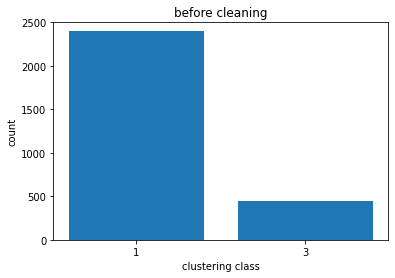

In [18]:
plt.figure(figsize=(6,4))
plt.bar(x = [1,2], height=df.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','3'])
plt.xlabel('clustering class')
plt.ylabel('count')
plt.ylim(top=2500)
plt.title('before cleaning')

In [19]:
df.describe()

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
count,3258.000000,2846.000000,2846.000000,2846.00000,2846.000000,2846.000000,2846.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000
mean,1.309392,7787.851722,7594.281799,3803.66409,3906.014055,1280.649684,1247.055517,0.522728,0.521500,0.001576,0.000877,0.000855,0.533156,0.497038,0.311371,0.310552,0.543871,0.537637,0.418330,0.420995,0.388551,0.388406,0.000763,0.000765,0.000884,0.000897,0.000777,0.000781,0.000906,0.000907,0.000805,0.000804,23275.425053,26310.903795,6318.703356,6313.195418,1902.342171,1899.755969,5140.837013,5692.026680,5246.847115,5484.991472,6657.745907,6066.066181,2965.865798,3025.788190,1703.782326,1378.136701,1508.354786,1341.218613,2706.236504,2838.818942,4229.225418,4386.540907,1825.907536,2094.697642
std,0.723341,741.421439,724.356454,478.94579,501.389721,247.163555,271.304276,0.036362,0.038188,0.000313,0.000064,0.000059,0.032895,0.033163,0.030569,0.032421,0.024310,0.025114,0.023412,0.024397,0.022799,0.020621,0.000026,0.000026,0.000065,0.000065,0.000029,0.000029,0.000042,0.000042,0.000038,0.000032,2760.471901,3082.920792,670.224741,673.308056,316.847560,325.531604,1098.224523,1237.746396,763.199119,779.981322,853.518595,765.077929,427.267638,457.128404,220.188726,177.266334,255.948144,242.958620,316.084881,325.055169,422.627743,439.791198,234.149872,263.555855
min,1.000000,5297.000000,5249.000000,1583.00000,1390.000000,455.000000,438.000000,0.250751,0.254980,0.000993,0.000712,0.000700,0.388355,0.385154,0.172164,0.172618,0.000000,0.000000,0.332241,0.340286,0.234679,0.259762,0.000673,0.000664,0.000746,0.000731,0.000000,0.000000,0.000764,0.000774,0.000677,0.000710,14933.500000,17378.300000,4514.690000,4440.030000,1083.620000,939.530000,2747.610000,2552.770000,3315.470000,3465.980000,4178.950000,3965.400000,1699.880000,1799.280000,1015.050000,871.440000,740.270000,645.650000,1936.870000,1974.420000,2908.390000,3058.730000,843.039000,1183.970000
25%,1.000000,7284.500000,7092.000000,3521.25000,3612.000000,1116.000000,1073.000000,0.501091,0.498775,0.001359,0.000837,0.000818,0.510744,0.474423,0.295581,0.293975,0.529891,0.523611,0.403590,0.405435,0.373557,0.374903,0.000746,0.000747,0.000845,0.000856,0.000761,0.000764,0.000877,0.000881,0.000779,0.000782,21339.300000,24188.275000,5841.547500,5836.032500,1673.170000,1665.582500,4420.322500,4875.882500,4732.810000,4932.927500,6066.970000,5536.445000,2669.137500,2699.355000,1552.285000,1256.455000,1328.880000,1168.642500,2514.017500,2641.240000,3936.345000,4080.005000,1675.790000,1925.245000
50%,1.000000,7763.500000,7562.500000,3807.50000,3910.500000,1275.000000,1249.000000,0.524316,0.524554,0.001520,0.000866,0.000847,0.534628,0.497467,0.313808,0.313474,0.545258,0.538732,0.418550,0.421238,0.388629,0.388470,0.000762,0.000764,0.000873,0.000888,0.000777,0.000781,0.000904,0.000904,0.000802,0.000803,23131.150000,26154.400000,6289.500000,6277.510000,1889.435000,1879.290000,4981.56000

In [20]:
df.isnull().sum()

kmeans_cluster_4      0
25011-2.0           412
25012-2.0           412
25019-2.0           412
25020-2.0           412
25021-2.0           412
25022-2.0           412
25094-2.0           676
25095-2.0           676
25109-2.0           676
25142-2.0           676
25143-2.0           676
25492-2.0           676
25493-2.0           676
25494-2.0           676
25495-2.0           676
25496-2.0           676
25497-2.0           676
25505-2.0           676
25506-2.0           676
25513-2.0           676
25514-2.0           676
25519-2.0           676
25520-2.0           676
25521-2.0           676
25522-2.0           676
25523-2.0           676
25524-2.0           676
25532-2.0           676
25533-2.0           676
25540-2.0           676
25541-2.0           676
25782-2.0           412
25783-2.0           412
25784-2.0           412
25785-2.0           412
25830-2.0           412
25831-2.0           412
25838-2.0           412
25839-2.0           412
25840-2.0           412
25841-2.0       

# remove missing values

In [21]:
df_fil = df.copy()
df_fil.dropna(axis='index', how='any',inplace=True)
  # drop rows that have ANY missing values
df_fil

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000993,1.0,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1001367,1.0,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
1003823,1.0,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
1004315,3.0,7774.0,7386.0,3662.0,3993.0,1419.0,1154.0,0.576219,0.592066,0.001249,0.000832,0.000795,0.557935,0.518180,0.331406,0.285294,0.550688,0.540415,0.443497,0.425165,0.400163,0.403540,0.000710,0.000734,0.000792,0.000837,0.000770,0.000788,0.000863,0.000898,0.000743,0.000750,23035.5,27176.8,6192.51,6100.30,1989.57,2095.65,3819.54,5083.01,4094.86,4470.47,6385.11,5952.27,2348.40,2268.51,1864.38,1367.66,1831.850,1502.120,2645.42,2665.90,4192.30,4237.17,1914.12,2132.89
1004449,1.0,7523.0,7673.0,2610.0,3705.0,1316.0,1508.0,0.594285,0.555879,0.001604,0.000782,0.000765,0.577567,0.480762,0.331424,0.353024,0.583016,0.579894,0.446387,0.438818,0.404958,0.400107,0.000745,0.000744,0.000844,0.000884,0.000764,0.000781,0.000889,0.000929,0.000781,0.000787,24366.2,27856.2,6587.04,6444.35,2118.58,1996.07,5865.49,7130.06,6526.02,5818.52,7316.77,6460.84,2892.63,2914.22,1350.34,1224.34,1498.140,1497.800,2519.22,2432.88,3369.10,4056.99,1993.78,2184.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6020782,1.0,7633.0,7364.0,3907.0,3712.0,1272.0,1087.0,0.527954,0.547128,0.001383,0.000864,0.000804,0.534200,0.471063,0.285926,0.304427,0.512333,0.498466,0.424116,0.415968,0.367044,0.377887,0.000762,0.000770,0.000864,0.000849,0.000752,0.000742,0.000927,0.000927,0.000800,0.000814,22566.8,26450.5,5455.98,5729.86,2034.72,2078.50,3979.83,4503.02,4963.26,4859.64,6270.59,6190.72,3275.17,3385.50,1698.42,1513.33,1267.220,1170.980,2625.89,2706.91,4078.88,4286.62,1648.08,2033.81
6021110,1.0,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.

In [22]:
# look at how many samples we have for each class after cleaning
df_fil.groupby('kmeans_cluster_4')['25011-2.0'].count()

kmeans_cluster_4
1.0    2184
3.0     398
Name: 25011-2.0, dtype: int64

Text(0.5, 1.0, 'after cleaning')

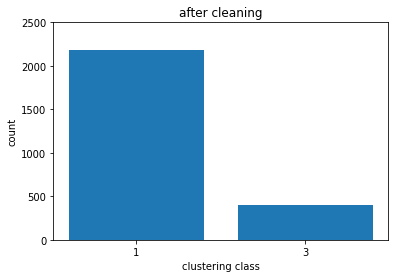

In [23]:
plt.figure(figsize=(6,4))
plt.bar(x = [1,2], height=df_fil.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','3'])
plt.xlabel('clustering class')
plt.ylabel('count')
plt.ylim(top=2500)
  # put it on the same scale as the original
plt.title('after cleaning')

In [24]:
df_fil.describe()

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
count,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000
mean,1.308288,7793.152208,7599.435321,3807.069713,3911.714562,1280.032533,1247.676220,0.522728,0.521500,0.001576,0.000877,0.000855,0.533156,0.497038,0.311371,0.310552,0.543871,0.537637,0.418330,0.420995,0.388551,0.388406,0.000763,0.000765,0.000884,0.000897,0.000777,0.000781,0.000906,0.000907,0.000805,0.000804,23290.596514,26328.861580,6323.561359,6317.750492,1905.463377,1902.042137,5139.950333,5691.673048,5251.280116,5490.321088,6662.700124,6071.525879,2968.361468,3027.097130,1705.934586,1380.676092,1510.047069,1343.031409,2704.330736,2837.241696,4234.569237,4392.557405,1828.756541,2097.739311
std,0.722313,746.280660,727.000871,481.392134,499.296815,246.447226,271.864746,0.036362,0.038188,0.000313,0.000064,0.000059,0.032895,0.033163,0.030569,0.032421,0.024310,0.025114,0.023412,0.024397,0.022799,0.020621,0.000026,0.000026,0.000065,0.000065,0.000029,0.000029,0.000042,0.000042,0.000038,0.000032,2772.705256,3079.744568,673.317964,673.922729,315.236555,323.030783,1096.067151,1240.517499,770.185256,786.843006,861.304746,771.758570,425.563432,459.083072,221.149305,176.960792,255.039100,242.387734,320.974329,329.617844,423.291065,440.481995,233.307133,263.021084
min,1.000000,5662.000000,5567.000000,1583.000000,1390.000000,455.000000,438.000000,0.250751,0.254980,0.000993,0.000712,0.000700,0.388355,0.385154,0.172164,0.172618,0.000000,0.000000,0.332241,0.340286,0.234679,0.259762,0.000673,0.000664,0.000746,0.000731,0.000000,0.000000,0.000764,0.000774,0.000677,0.000710,14933.500000,17378.300000,4514.690000,4440.030000,1083.620000,939.530000,2747.610000,2552.770000,3359.300000,3465.980000,4178.950000,3965.400000,1699.880000,1799.280000,1015.050000,871.440000,740.270000,645.650000,1936.870000,1974.420000,2981.210000,3058.730000,994.659000,1183.970000
25%,1.000000,7289.250000,7087.750000,3517.250000,3612.250000,1117.000000,1073.250000,0.501091,0.498775,0.001359,0.000837,0.000818,0.510744,0.474423,0.295581,0.293975,0.529891,0.523611,0.403590,0.405435,0.373557,0.374903,0.000746,0.000747,0.000845,0.000856,0.000761,0.000764,0.000877,0.000881,0.000779,0.000782,21338.550000,24193.025000,5837.560000,5839.520000,1676.407500,1666.247500,4427.045000,4874.165000,4728.835000,4925.722500,6066.560000,5536.880000,2672.717500,2705.477500,1553.192500,1258.420000,1329.935000,1170.855000,2510.087500,2638.782500,3938.392500,4080.005000,1677.807500,1928.437500
50%,1.000000,7772.500000,7569.000000,3810.000000,3922.000000,1275.000000,1250.000000,0.524316,0.524554,0.001520,0.000866,0.000847,0.534628,0.497467,0.313808,0.313474,0.545258,0.538732,0.418550,0.421238,0.388629,0.388470,0.000762,0.000764,0.000873,0.000888,0.000777,0.000781,0.000904,0.000904,0.000802,0.000803,23162.200000,26157.050000,6291.760000,6277.510000,1890.115000,1882.135000,4984

In [25]:
df_fil.isnull().sum().sum()

0

In [ ]:
5772-4555

1217

In [ ]:
df_fil.to_csv('cleaned_data/brain_56cols_kmeans4_binary_filtered.csv', index=True)

# train test split

In [ ]:
df_fil = pd.read_csv('cleaned_data/brain_56cols_kmeans4_binary_filtered.csv')
df_fil.set_index('eid', inplace=True)

In [ ]:
train, test = train_test_split(df_fil, test_size=0.25, random_state=42, stratify=df_fil['kmeans_cluster_4'])
  # stratify against the target column so both train and test have the same proportion of classes

In [ ]:
print(train.shape)
print(test.shape)

(1936, 56)
(646, 56)


Text(0.5, 0.98, 'distributions of classes after split')

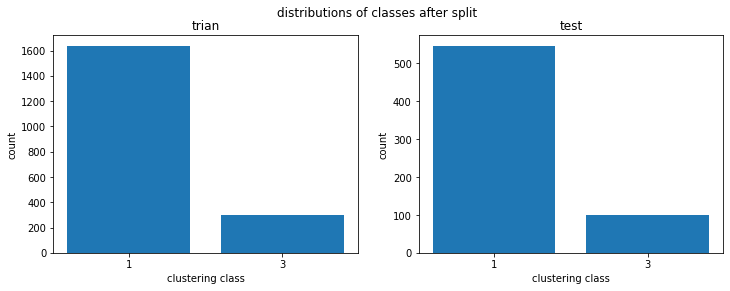

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(x = [1,2], height=train.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','3'])
ax[0].set_xlabel('clustering class')
ax[0].set_ylabel('count')
# ax[0].set_ylim(top=2000)
  # put it on the same scale as the original
ax[0].set_title('trian')

ax[1].bar(x = [1,2], height=test.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','3'])
ax[1].set_xlabel('clustering class')
ax[1].set_ylabel('count')
# ax[1].set_ylim(top=2500)
  # put it on the same scale as the original
ax[1].set_title('test')
fig.suptitle('distributions of classes after split')

In [ ]:
train

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2579587,1.0,8079.0,7956.0,3642.0,3754.0,1275.0,1267.0,0.553621,0.547649,0.001452,0.000871,0.000835,0.518366,0.490956,0.323911,0.347123,0.562338,0.559713,0.411800,0.456871,0.420085,0.420221,0.000788,0.000782,0.000860,0.000897,0.000763,0.000773,0.000865,0.000908,0.000791,0.000810,24112.9,28951.4,6251.77,6509.02,2067.36,2028.98,5630.62,7890.91,5273.17,5237.53,6716.62,6412.88,3197.92,3295.46,1916.68,1348.31,1606.91,1517.46,2931.48,3297.16,4024.73,4044.05,1724.33,2194.42
2435445,1.0,7472.0,7415.0,3041.0,3158.0,1144.0,1084.0,0.550018,0.524012,0.001394,0.000840,0.000830,0.496835,0.484849,0.327375,0.330577,0.540178,0.530623,0.451650,0.440151,0.403228,0.373021,0.000750,0.000748,0.000837,0.000833,0.000735,0.000741,0.000842,0.000865,0.000788,0.000799,25407.9,28704.0,6606.59,6308.47,1950.99,2126.91,4634.95,5394.11,5675.37,5367.46,6815.84,5751.59,3166.96,3116.51,1288.96,1169.42,1172.42,1362.21,2600.33,2744.90,3950.41,4191.94,1937.74,2094.05
3885370,1.0,7717.0,7520.0,3880.0,4266.0,1427.0,1360.0,0.535332,0.565931,0.001427,0.000855,0.000829,0.555682,0.536407,0.335845,0.302041,0.572880,0.561198,0.407888,0.385973,0.408273,0.401286,0.000735,0.000746,0.000838,0.000887,0.000736,0.000742,0.000926,0.000973,0.000783,0.000768,21318.6,26220.4,6256.01,5923.64,2617.70,2747.10,5096.97,5300.50,5180.78,5627.79,6230.10,5293.46,3207.36,2765.51,1695.63,1241.37,1402.28,1274.05,2638.87,2593.93,4185.23,4458.58,1780.06,2022.52
1260149,1.0,8096.0,7745.0,4467.0,4107.0,1613.0,1451.0,0.545959,0.548611,0.001377,0.000800,0.000830,0.542431,0.483696,0.323540,0.298166,0.563491,0.533023,0.419891,0.434321,0.368647,0.396456,0.000771,0.000763,0.000845,0.000930,0.000755,0.000784,0.000887,0.000883,0.000800,0.000787,24290.7,27279.0,6687.70,6498.42,2423.42,2252.60,4734.97,4659.03,5372.23,5723.58,6765.66,6150.28,3615.02,3272.08,1823.21,1494.95,1945.32,1191.94,2682.05,2817.26,4542.58,4793.35,1931.79,2152.42
2302152,1.0,7862.0,7529.0,4072.0,4213.0,1538.0,1049.0,0.570075,0.565590,0.001241,0.000831,0.000840,0.557616,0.497598,0.296509,0.302773,0.532329,0.538107,0.417947,0.464237,0.381882,0.396285,0.000753,0.000758,0.000902,0.000843,0.000772,0.000763,0.000929,0.000912,0.000797,0.000799,23545.5,24069.5,6329.57,6304.98,1846.85,1588.99,4595.19,5330.12,5313.27,5436.36,7347.79,6987.85,2704.32,2751.01,1548.75,1306.75,1528.88,1369.54,2708.05,2628.50,4280.62,4310.17,2095.75,2196.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475107,1.0,7257.0,7146.0,3956.0,4037.0,1200.0,1168.0,0.487360,0.474356,0.001393,0.000878,0.000867,0.556381,0.526042,0.323692,0.346021,0.552626,0.531193,0.469960,0.418863,0.424916,0.393762,0.000760,0.000767,0.000835,0.000831,0.000750,0.000766,0.000947,0.001004,0.000762,0.000767,21863.4,23523.6,6009.70,6131.89,1697.25,1810.87,4684.06,5857.20,4416.11,4920.15,6346.36,5683.21,3183.37,3203.62,1486.21,1107.34,1305.43,1276.85,2546.33,2652.04,3976.52,4078.52,1709.54,1802.17
1086954,1.0,7918.0,7350.0,3952.0,4078.0,1077.0,1006.0,0.546993,0.549811,0.001304,0.000841,0.000847,0.549026,0.524608,0.316237,0.317104,0.533127,0.528774,0.414781,0.425949,0.371139,0.377035,0.000763,0.000755,0.000896,0.000862,0.000748,0.000755,0.000907,0.000856,0.000834,0.000831,23986.0,24408.6,6297.34,6606.30,1817.49

In [ ]:
# split into X and y
X_train = train.drop('kmeans_cluster_4', axis=1)
y_train = train['kmeans_cluster_4']
X_test = test.drop('kmeans_cluster_4', axis=1)
y_test = test['kmeans_cluster_4']

In [ ]:
# rename class 3 to be value 0, so we have binary classification of 0,1
y_train.replace(3,0,inplace=True)
y_test.replace(3,0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


# PCA on brain features

In [67]:
# we need integer indices to list which row is in which cluster
#  because PCA will be an array, not a dataframe with 'eid' as an index, so we can only access its rows with integer indices
temp = df_fil.reset_index()['kmeans_cluster_4']
lst = temp[temp==3].index
lst

Int64Index([   3,   12,   20,   23,   25,   26,   31,   36,   45,   51,
            ...
            2516, 2518, 2523, 2529, 2545, 2552, 2555, 2558, 2562, 2573],
           dtype='int64', length=398)

In [68]:
df_fil.iloc[lst,:]

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1004315,3.0,7774.0,7386.0,3662.0,3993.0,1419.0,1154.0,0.576219,0.592066,0.001249,0.000832,0.000795,0.557935,0.518180,0.331406,0.285294,0.550688,0.540415,0.443497,0.425165,0.400163,0.403540,0.000710,0.000734,0.000792,0.000837,0.000770,0.000788,0.000863,0.000898,0.000743,0.000750,23035.5,27176.8,6192.51,6100.30,1989.57,2095.65,3819.54,5083.01,4094.86,4470.47,6385.11,5952.27,2348.40,2268.51,1864.38,1367.66,1831.850,1502.120,2645.42,2665.90,4192.30,4237.17,1914.12,2132.89
1016421,3.0,6781.0,6561.0,3669.0,4011.0,1014.0,959.0,0.494321,0.514459,0.001547,0.000858,0.000808,0.577971,0.499362,0.334976,0.280601,0.555798,0.553924,0.379672,0.427804,0.413104,0.396933,0.000742,0.000721,0.000811,0.000918,0.000737,0.000744,0.000907,0.000949,0.000751,0.000773,21639.3,25331.0,5001.12,5008.52,1412.69,1369.07,4762.69,4100.76,4560.80,4759.83,5664.48,4558.21,2317.65,2849.28,1510.16,1317.80,1158.890,1044.200,2327.15,2610.87,3901.81,4035.44,1381.92,1762.35
1027543,3.0,7196.0,6827.0,3441.0,3167.0,1354.0,1497.0,0.512685,0.538932,0.001677,0.000835,0.000817,0.577297,0.517306,0.294599,0.293968,0.559882,0.543763,0.417364,0.423986,0.389782,0.390575,0.000733,0.000750,0.000910,0.000944,0.000753,0.000763,0.000891,0.000921,0.000804,0.000779,18621.3,20855.8,5016.13,5016.34,1469.14,1431.75,4125.72,5026.49,4178.52,3920.66,5010.00,4378.25,2626.71,2393.39,1385.63,1175.47,950.951,912.661,2525.11,2613.40,3840.82,3908.80,1626.60,1745.37
1034741,3.0,6634.0,6441.0,3384.0,2930.0,1067.0,1661.0,0.425546,0.428009,0.002106,0.000989,0.000882,0.488995,0.504773,0.324442,0.312921,0.557699,0.557328,0.416224,0.449349,0.418570,0.382652,0.000729,0.000767,0.000918,0.000925,0.000797,0.000802,0.000939,0.000930,0.000817,0.000821,21837.7,23642.3,5314.19,5888.84,1636.08,1318.28,3499.76,5230.61,4024.46,4366.70,6285.79,5711.47,2946.33,2707.53,1550.21,1424.53,1197.880,1319.250,2621.65,2847.44,3878.65,3995.10,1351.58,1567.43
1035948,3.0,9736.0,9641.0,4317.0,4696.0,1081.0,1378.0,0.590959,0.589271,0.001040,0.000789,0.000813,0.613214,0.562147,0.351637,0.333047,0.540068,0.544926,0.468333,0.431419,0.442263,0.421250,0.000744,0.000729,0.000815,0.000836,0.000756,0.000766,0.000863,0.000839,0.000785,0.000783,29894.0,31037.2,7898.19,7419.80,1770.67,1701.98,5994.24,7383.09,6224.93,6335.10,8857.96,7069.04,3059.68,3298.85,2162.57,1743.53,1931.170,2479.100,3348.79,3488.20,4611.07,4830.35,2041.86,2787.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5984302,3.0,7449.0,7043.0,3623.0,3991.0,1009.0,1113.0,0.518808,0.481448,0.001367,0.000906,0.000928,0.478780,0.426542,0.273962,0.308861,0.532407,0.518190,0.382325,0.408215,0.383363,0.370427,0.000848,0.000832,0.000913,0.000926,0.000805,0.000807,0.000947,0.000940,0.000794,0.000810,23253.3,22764.2,5424.33,5112.90,2080.52,2217.11,4605.90,5251.57,4472.75,4937.54,5754.05,4548.41,2810.68,2977.60,2046.13,1344.47,1561.040,1371.200,2719.93,2787.14,3869.77,4191.75,1772.77,2615.14
5987033,3.0,7846.0,7608.0,3658.0,3968.0,1430.0,1135.0,0.538274,0.509205,0.001728,0.000822,0.000884,0.556489,0.450010,0.356731,0.313092,0.553844,0.554595,0.401793,0.429356,0.372562,0.373942,0.000735,0.000697,0.000816,0.000887,0.000749,0.000747,0.000939,0.000910,0.000771,0.000777,23710.6,26623.2,6634.45,6816.1

In [69]:
# create the cluster list, where each list within contains the index of the rows that belong to this cluster
kmeans_clusters=[]
kmeans_clusters.append(temp[temp==1].index)
kmeans_clusters.append(temp[temp==3].index)

In [70]:
len(kmeans_clusters)

2

In [71]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them


df_fil_feat = df_fil.drop('kmeans_cluster_4', axis=1)

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances

st = StandardScaler()
df_fil_feat_st = st.fit_transform(df_fil_feat)

## 2-comp PCA visualization

In [72]:
# instantiate PCA object
my_pca2 = PCA(n_components=2)

df_fil_feat_st_pca2 = my_pca2.fit_transform(df_fil_feat_st)
  # returns ndarray of shape (n_samples, n_components) Transformed values.
  # this is not a dataframe

In [73]:
# look into variance explained
print(my_pca2.explained_variance_)
  # The variance i.e. the eigenvalues of the covariance matrix
  # The amount of variance explained by each of the selected components.
print(my_pca2.explained_variance_ratio_)
  # Percentage of variance explained by each of the selected components versue overall variance in the og data.
  # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
print(my_pca2.explained_variance_ratio_.cumsum())

[13.53447265  5.78789652]
[0.24598601 0.10519373]
[0.24598601 0.35117974]


In [74]:
print(df_fil_feat_st.shape)
print(df_fil_feat_st_pca2.shape)

(2582, 55)
(2582, 2)


In [75]:
# check that our pca rows per cluster is the same as our original dataframes rows per cluster
len(df_fil_feat_st_pca2[kmeans_clusters[0]][:,0])

2184

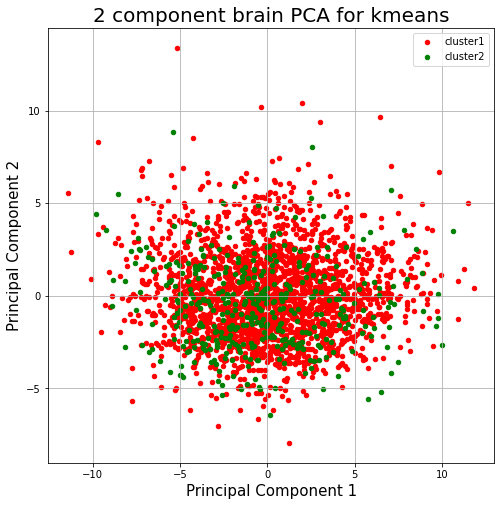

In [76]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component brain PCA for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_fil_feat_st_pca2[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

plt.show()

## 3-comp PCA visualization

In [77]:
# instantiate PCA object
my_pca3 = PCA(n_components=3)
df_fil_feat_st_pca3 = my_pca3.fit_transform(df_fil_feat_st)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [78]:
# look into variance explained
print(my_pca3.explained_variance_)
  # The variance i.e. the eigenvalues of the covariance matrix
  # The amount of variance explained by each of the selected components.
print(my_pca3.explained_variance_ratio_)
  # Percentage of variance explained by each of the selected components versue overall variance in the og data.
  # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
print(my_pca3.explained_variance_ratio_.cumsum())

[13.53447265  5.78789652  3.56256567]
[0.24598601 0.10519373 0.06474883]
[0.24598601 0.35117974 0.41592857]


In [79]:
print(df_fil_feat_st.shape)
print(df_fil_feat_st_pca3.shape)

(2582, 55)
(2582, 3)


In [81]:
len(df_fil_feat_st_pca3[kmeans_clusters[0]][:,0])

2184

matplotlib.axes._subplots.Axes3DSubplot

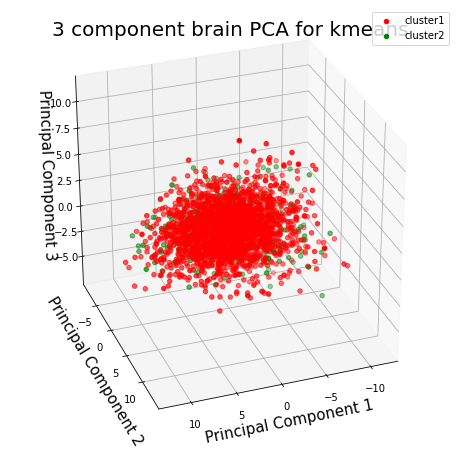

In [83]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component brain PCA for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_fil_feat_st_pca3[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 70
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 30
  #elev is the angle between the eye and the xy plane.
# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
type(ax)

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


## 2-comp TSNE visualization

In [84]:
# instantiate tsne object
my_tsne2 = TSNE(n_components=2)

df_fil_feat_st_tsne2 = my_tsne2.fit_transform(df_fil_feat_st)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [85]:
# # look into variance explained
# print(my_pca2.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca2.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca2.explained_variance_ratio_.cumsum())

In [86]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne2.kl_divergence_

2.3957743644714355

In [87]:
print(df_fil_feat_st.shape)
print(df_fil_feat_st_tsne2.shape)

(2582, 55)
(2582, 2)


In [88]:
len(df_fil_feat_st_tsne2[kmeans_clusters[0]][:,0])

2184

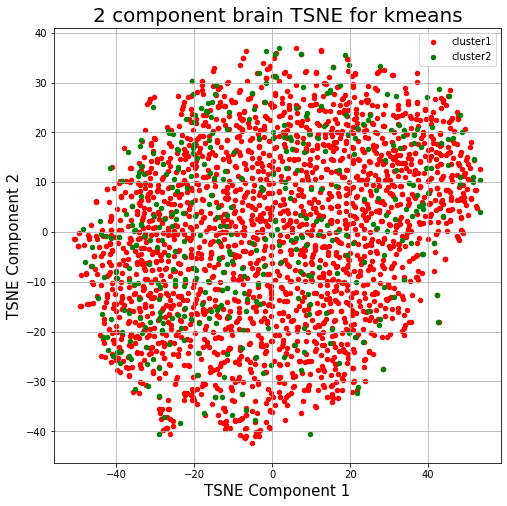

In [89]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_title('2 component brain TSNE for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_fil_feat_st_tsne2[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

plt.show()

## 3-comp TSNE visualization

In [90]:
# instantiate TSNE object
my_tsne3 = TSNE(n_components=3)
df_fil_feat_st_tsne3 = my_tsne3.fit_transform(df_fil_feat_st)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [91]:
# # look into variance explained
# print(my_pca3.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca3.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca3.explained_variance_ratio_.cumsum())

In [92]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne3.kl_divergence_

2.2626121044158936

In [93]:
print(df_fil_feat_st.shape)
print(df_fil_feat_st_tsne3.shape)

(2582, 55)
(2582, 3)


In [94]:
len(df_fil_feat_st_tsne3[kmeans_clusters[0]][:,0])

2184

matplotlib.axes._subplots.Axes3DSubplot

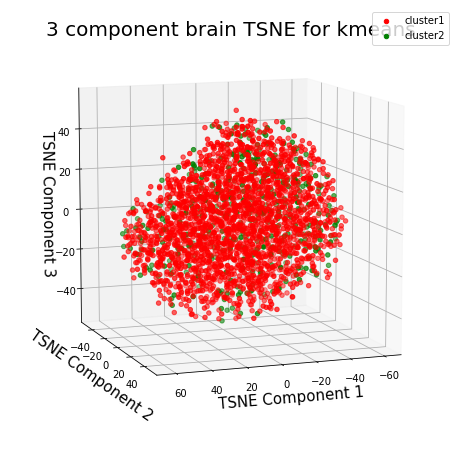

In [95]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_zlabel('TSNE Component 3', fontsize = 15)
ax.set_title('3 component brain TSNE for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_fil_feat_st_tsne3[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 70
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 10
  #elev is the angle between the eye and the xy plane.
# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
type(ax)

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


# binary classification

view all mutliclass `sklearn` models available [here](https://scikit-learn.org/stable/modules/multiclass.html).

# binary logistic regression

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='auto',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_norm,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train.iloc[:2])
print(lr.predict(X_train_norm[:2]))

eid
2579587    1.0
2435445    1.0
Name: kmeans_cluster_4, dtype: float64
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train, lr.predict(X_train_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.8460743801652892
0.8452012383900929


In [ ]:
train_f1 = f1_score(y_train, lr.predict(X_train_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.7755287267547532
0.7742950942298501


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, lr.predict(X_train_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,0,298
true 1,0,1638


Text(0.5, 1.0, 'train confusion')

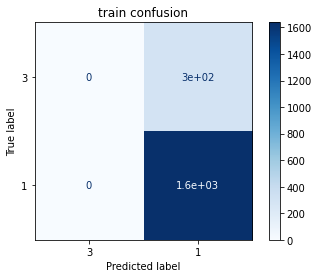

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,0,100
true 1,0,546


Text(0.5, 1.0, 'test confusion')

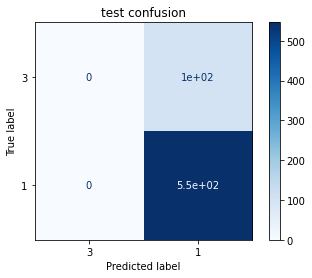

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([0., 1.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(1, 55)

In [ ]:
# coef_ corresponds to outcome 1 (True) and -coef_ corresponds to outcome 0 (False).

class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = -lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_1.sort_values(by='coef',axis=0,ascending=False).head(10))

,coef
25785-2.0,0.001145
25784-2.0,0.001091
25109-2.0,0.000918
25888-2.0,0.000819
25841-2.0,0.000796
25783-2.0,0.000791
25840-2.0,0.000787
25849-2.0,0.000779
25012-2.0,0.000752
25011-2.0,0.000745


# multiclass random forest

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train.iloc[:2])
print(rf.predict(X_train.iloc[:2,:]))

eid
2579587    1.0
2435445    1.0
Name: kmeans_cluster_4, dtype: float64
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train, rf.predict(X_train))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

0.9989669421487604
0.8436532507739938


In [ ]:
train_f1 = f1_score(y_train, rf.predict(X_train), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

0.9989655181429545
0.7764111396054098


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, rf.predict(X_train))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,296,2
true 1,0,1638


Text(0.5, 1.0, 'train confusion')

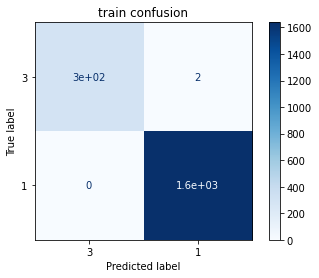

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,1,99
true 1,2,544


Text(0.5, 1.0, 'test confusion')

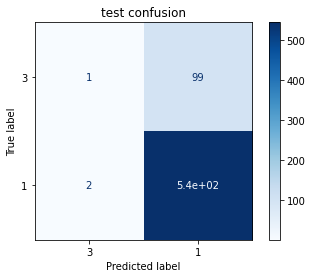

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([0., 1.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

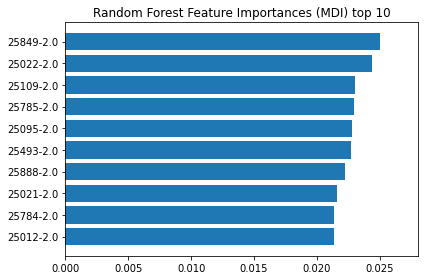

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.028)
fig.tight_layout()
plt.show()

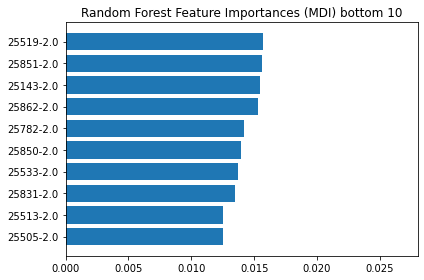

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.028)
fig.tight_layout()
plt.show()

# multiclass knn

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_norm,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train.iloc[0])
print(knn.predict(X_train_norm[0].reshape(1, -1)))

1.0
[1.]


In [ ]:
train_acc = skm.accuracy_score(y_train, knn.predict(X_train_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.8517561983471075
0.8281733746130031


In [ ]:
train_f1 = f1_score(y_train, knn.predict(X_train_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.806515975566339
0.7756271979783972


In [ ]:
for i in range(2,16):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train_norm,y_train)
  train_acc = skm.accuracy_score(y_train, knn.predict(X_train_norm))
  test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
  print(f'i={i}')
  print(train_acc)
  print(test_acc)
  train_f1 = f1_score(y_train, knn.predict(X_train_norm), average='weighted')
  test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
  print(train_f1)
  print(test_f1)
  print(80*'-')

i=2
0.8796487603305785
0.6594427244582043
0.8919542139272068
0.6965474873810571
--------------------------------------------------------------------------------
i=3
0.8589876033057852
0.8157894736842105
0.833255166170242
0.7747150447300304
--------------------------------------------------------------------------------
i=4
0.8460743801652892
0.7708978328173375
0.8356756442496602
0.7577406946726831
--------------------------------------------------------------------------------
i=5
0.8517561983471075
0.8281733746130031
0.806515975566339
0.7756271979783972
--------------------------------------------------------------------------------
i=6
0.8486570247933884
0.8065015479876161
0.8171387846292357
0.7709771727745176
--------------------------------------------------------------------------------
i=7
0.8481404958677686
0.8359133126934984
0.7926387482442099
0.7823628543976575
--------------------------------------------------------------------------------
i=8
0.8450413223140496
0.83126934984

## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, knn.predict(X_train_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,0,298
true 1,1,1637


Text(0.5, 1.0, 'train confusion')

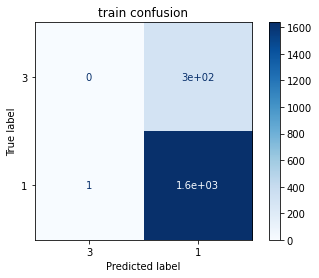

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,1,99
true 1,1,545


Text(0.5, 1.0, 'test confusion')

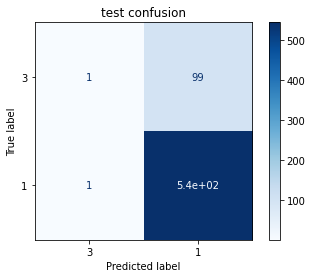

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.

# Re-sampling data - SMOTE

Our data is very imbalanced. We don't have nearly as many samples belonging to classes 2 and 3 as the ones belong to classes 1 and 4. 

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. 

Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or **SMOTE** for short.

View tutorial [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [ ]:
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)

0.4.3


In [ ]:
y_train.value_counts()

1.0    1638
0.0     298
Name: kmeans_cluster_4, dtype: int64

In [ ]:
# must run all codes until the train test split section is done

# instantiate a SMOTE object
oversamp = SMOTE()

# fit and transform on the training set only!
X_train_smo, y_train_smo = oversamp.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y_train_smo).value_counts()

0.0    1638
1.0    1638
dtype: int64

# multiclass logistic regression on SMOTE

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_smo_norm = mm.fit_transform(X_train_smo)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='auto',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_smo_norm,y_train_smo)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train_smo[:2])
print(lr.predict(X_train_smo_norm[:2]))

[1. 1.]
[0. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, lr.predict(X_train_smo_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.6541514041514042
0.6068111455108359


In [ ]:
train_f1 = f1_score(y_train_smo, lr.predict(X_train_smo_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.6537246975007163
0.6608898845992793


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, lr.predict(X_train_smo_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,1129,509
true 1,624,1014


Text(0.5, 1.0, 'train confusion')

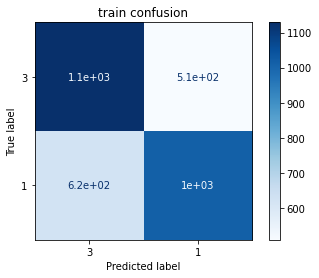

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,58,42
true 1,212,334


Text(0.5, 1.0, 'test confusion')

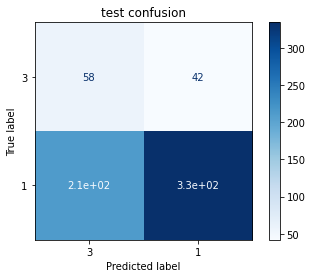

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([0., 1.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(1, 55)

In [ ]:
class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = -lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_1.sort_values(by='coef',axis=0,ascending=False).head(10))

,coef
25011-2.0,3.367561
25888-2.0,3.273115
25540-2.0,3.102801
25021-2.0,2.919827
25109-2.0,1.504272
25495-2.0,1.477507
25513-2.0,1.472578
25840-2.0,1.456412
25142-2.0,1.334496
25523-2.0,1.042062


# multiclass random forest on SMOTE

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train_smo,y_train_smo)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train_smo[:2])
print(rf.predict(X_train_smo[:2,:]))

[1. 1.]
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, rf.predict(X_train_smo))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

1.0
0.7631578947368421


In [ ]:
train_f1 = f1_score(y_train_smo, rf.predict(X_train_smo), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

1.0
0.7527521580305747


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, rf.predict(X_train_smo))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,1638,0
true 1,0,1638


Text(0.5, 1.0, 'train confusion')

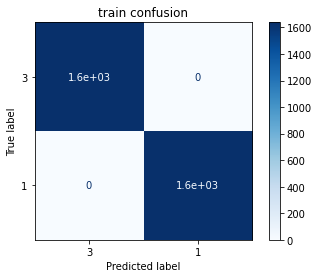

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,14,86
true 1,67,479


Text(0.5, 1.0, 'test confusion')

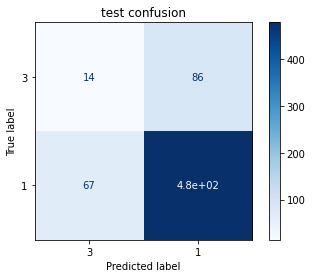

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([0., 1.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

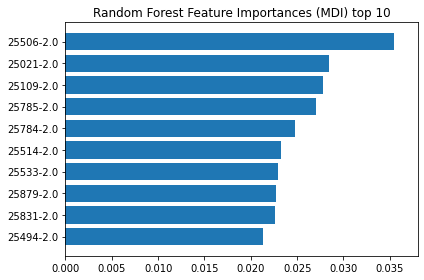

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.038)
fig.tight_layout()
plt.show()

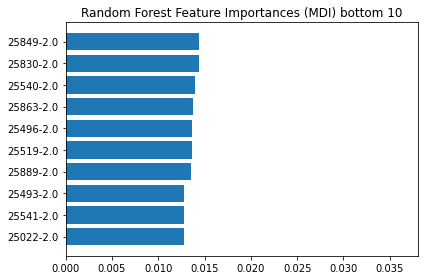

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.038)
fig.tight_layout()
plt.show()

# multiclass knn on SMOTE

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_smo_norm = mm.fit_transform(X_train_smo)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_smo_norm,y_train_smo)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train_smo[0])
print(knn.predict(X_train_smo_norm[0].reshape(1, -1)))

1.0
[0.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, knn.predict(X_train_smo_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.6965811965811965
0.3498452012383901


In [ ]:
train_f1 = f1_score(y_train_smo, knn.predict(X_train_smo_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.6659513144699198
0.3883113561198669


In [ ]:
for i in range(2,11):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train_smo_norm,y_train_smo)
  train_acc = skm.accuracy_score(y_train_smo, knn.predict(X_train_smo_norm))
  test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
  print(f'i={i}')
  print(train_acc)
  print(test_acc)
  train_f1 = f1_score(y_train_smo, knn.predict(X_train_smo_norm), average='weighted')
  test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
  print(train_f1)
  print(test_f1)
  print(80*'-')

i=2
0.7054334554334555
0.33126934984520123
0.6774455866578662
0.3585752506032932
--------------------------------------------------------------------------------
i=3
0.7741147741147741
0.38854489164086686
0.7619694722686541
0.4408793751425163
--------------------------------------------------------------------------------
i=4
0.652014652014652
0.3126934984520124
0.6040699804592086
0.333292094902002
--------------------------------------------------------------------------------
i=5
0.6965811965811965
0.3498452012383901
0.6659513144699198
0.3883113561198669
--------------------------------------------------------------------------------
i=6
0.6315628815628815
0.30030959752321984
0.5739151227172921
0.3104547057754723
--------------------------------------------------------------------------------
i=7
0.6599511599511599
0.32972136222910214
0.6163853780367821
0.3516690675778171
--------------------------------------------------------------------------------
i=8
0.6101953601953602
0.2863777

## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, knn.predict(X_train_smo_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,1628,10
true 1,1308,330


Text(0.5, 1.0, 'train confusion')

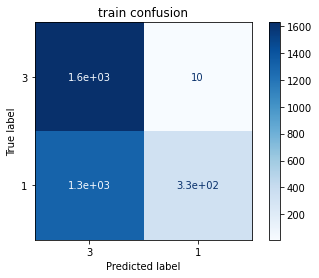

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,91,9
true 1,466,80


Text(0.5, 1.0, 'test confusion')

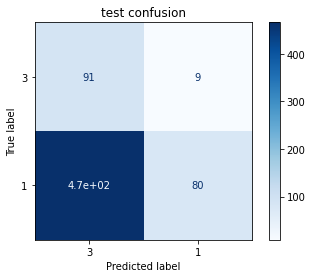

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.

# Re-sampling data - ADASYN

Our data is very imbalanced. We don't have nearly as many samples belonging to classes 2 and 3 as the ones belong to classes 1 and 4. 

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class.

That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

This modification to SMOTE is referred to as the Adaptive Synthetic Sampling Method, or ADASYN.

View tutorial [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

In [ ]:
from imblearn.over_sampling import ADASYN
print(imblearn.__version__)

0.4.3


In [ ]:
y_train.value_counts()

1.0    1638
0.0     298
Name: kmeans_cluster_4, dtype: int64

In [ ]:
# must run all codes until the train test split section is done

# instantiate a ADASYN object
oversamp = ADASYN()

# fit and transform on the training set only!
X_train_ada, y_train_ada = oversamp.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y_train_ada).value_counts()

1.0    1638
0.0    1552
dtype: int64

# multiclass logistic regression on ADASYN

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_ada_norm = mm.fit_transform(X_train_ada)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='auto',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_ada_norm,y_train_ada)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train_ada[0])
print(lr.predict(X_train_ada_norm[0].reshape(1, -1)))

1.0
[0.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, lr.predict(X_train_ada_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.6285266457680251
0.6145510835913313


In [ ]:
train_f1 = f1_score(y_train_ada, lr.predict(X_train_ada_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.6285940099597139
0.667064437651755


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, lr.predict(X_train_ada_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,980,572
true 1,613,1025


Text(0.5, 1.0, 'train confusion')

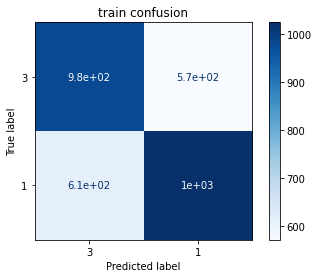

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,55,45
true 1,204,342


Text(0.5, 1.0, 'test confusion')

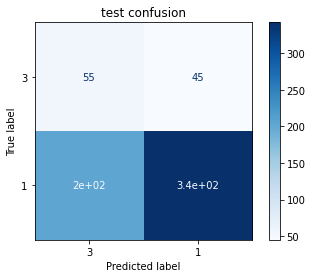

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([0., 1.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(1, 55)

In [ ]:
class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = -lr.coef_[0],index=X_train.columns, columns=['coef'])
# class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_1.sort_values(by='coef',axis=0,ascending=True).head(10))

,coef
25514-2.0,-2.949426
25022-2.0,-2.220483
25541-2.0,-2.137826
25846-2.0,-1.958424
25889-2.0,-1.878678
25879-2.0,-1.800332
25524-2.0,-1.516549
25094-2.0,-1.499075
25496-2.0,-1.276853
25848-2.0,-1.202917


# multiclass random forest on ADASYN

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train_ada,y_train_ada)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train_ada[:2])
print(rf.predict(X_train_ada[:2,:]))

[1. 1.]
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, rf.predict(X_train_ada))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

1.0
0.7770897832817337


In [ ]:
train_f1 = f1_score(y_train_ada, rf.predict(X_train_ada), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

1.0
0.7617323061415509


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, rf.predict(X_train_ada))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,1552,0
true 1,0,1638


Text(0.5, 1.0, 'train confusion')

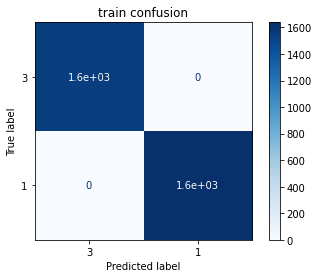

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,14,86
true 1,58,488


Text(0.5, 1.0, 'test confusion')

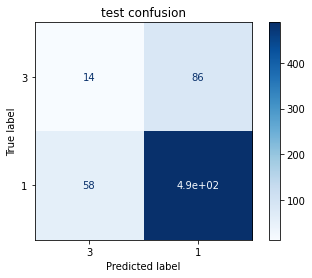

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([0., 1.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

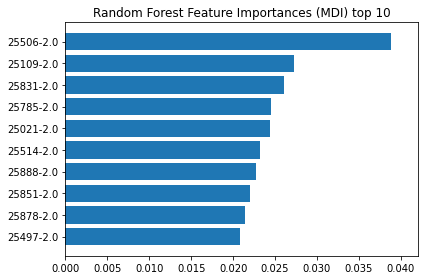

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.042)
fig.tight_layout()
plt.show()

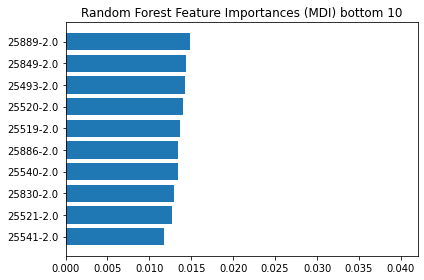

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.042)
fig.tight_layout()
plt.show()

# multiclass knn on ADASYN

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_ada_norm = mm.fit_transform(X_train_ada)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_ada_norm,y_train_ada)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train_ada[0])
print(knn.predict(X_train_ada_norm[0].reshape(1, -1)))

1.0
[0.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, knn.predict(X_train_ada_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.6896551724137931
0.33900928792569657


In [ ]:
train_f1 = f1_score(y_train_ada, knn.predict(X_train_ada_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.6599778939159988
0.3754788976222968


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, knn.predict(X_train_ada_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
train_cm_df

,predicted 3,predicted 1
true 3,1552,0
true 1,990,648


Text(0.5, 1.0, 'train confusion')

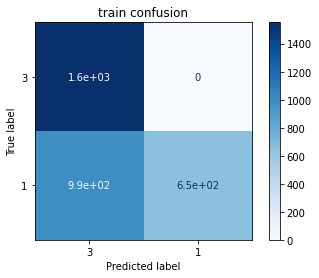

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 3', 'true 1'],
                     columns=['predicted 3', 'predicted 1'])
test_cm_df

,predicted 3,predicted 1
true 3,80,20
true 1,407,139


Text(0.5, 1.0, 'test confusion')

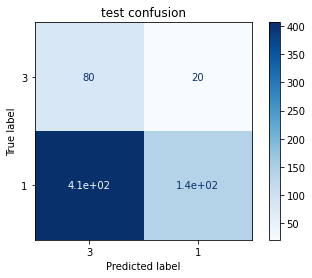

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[3,1])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.